In [2]:
import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

import keijzer_exogan as ke

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

from sklearn.metrics import r2_score

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab

# Initialize default seaborn layout
sns.set_palette(sns.hls_palette(8, l=.3, s=.8))
sns.set(style='ticks') 

In [3]:
df = pd.read_csv('Validation error of 3000 images')
df.head()

,Unnamed: 0,planet_mass_error,temp_profile_error,ch4_mixratio_error,planet_radius_error,h2o_mixratio_error,co2_mixratio_error,co_mixratio_error,planet_mass_real,temp_profile_real,...,h2o_mixratio_real,co2_mixratio_real,co_mixratio_real,planet_mass_inpainted,temp_profile_inpainted,ch4_mixratio_inpainted,planet_radius_inpainted,h2o_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted
0,0,-27.067264,78.338515,-15.882895,-8.545976,149.951446,-5.627198,47.294869,3.289867e+27,888.888888,...,-2.302585,-34.538777,-16.629781,2.399390e+27,1585.231245,-29.053019,9.590463e+07,-5.755345,-32.595212,-24.494815
1,0,8.379777,109.309080,-0.935060,9.783388,0.732313,-2.399434,29.458702,2.783733e+27,444.444418,...,-13.047982,-27.375179,-2.302585,3.017004e+27,930.262521,-23.570897,1.961406e+07,-13.143535,-26.718329,-2.980897
2,0,-6.150364,-7.622564,-1.272850,-33.593059,-1.936941,-4.428362,-8.657057,2.783733e+27,1555.555582,...,-16.629781,-13.047982,-20.211580,2.612524e+27,1436.982363,-27.026734,4.642576e+06,-16.307672,-12.470171,-18.461852
3,0,-64.978869,11.050115,7.124579,-5.497482,6.899089,-3.083765,-20.175066,3.289867e+27,1555.555582,...,-9.466183,-23.793379,-34.538777,1.152149e+27,1727.446258,-2.466634,4.771553e+07,-10.119264,-23.059648,-27.570556
4,0,-30.767302,-7.528773,26.308812,-4.482115,-5.761838,15.129403,24.989892,1.265333e+27,1777.777791,...,-16.629781,-13.047982,-23.793379,8.760244e+26,1643.932939,-7.432496,4.822820e+07,-15.671600,-15.022064,-29.739319


In [4]:
df.describe()

,Unnamed: 0,planet_mass_error,temp_profile_error,ch4_mixratio_error,planet_radius_error,h2o_mixratio_error,co2_mixratio_error,co_mixratio_error,planet_mass_real,temp_profile_real,...,h2o_mixratio_real,co2_mixratio_real,co_mixratio_real,planet_mass_inpainted,temp_profile_inpainted,ch4_mixratio_inpainted,planet_radius_inpainted,h2o_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted
count,2999.0,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2.999000e+03,2999.000000,...,2999.000000,2999.000000,2999.000000,2.999000e+03,2999.000000,2999.000000,2.999000e+03,2999.000000,2999.000000,2999.000000
mean,0.0,-36.565768,NaN,5.790602,-5.681730,18.725311,5.181104,21.211135,1.563377e+27,987.736653,...,-18.188384,-18.556238,-18.446359,1.871681e+27,1076.630718,-18.150077,5.348007e+07,-18.145564,-18.198371,-17.722427
std,0.0,375.571108,NaN,30.028403,17.962188,78.057769,27.505077,126.499496,1.457062e+27,643.823522,...,10.281201,10.375732,10.013937,1.246268e+27,545.157222,9.340582,3.090586e+07,9.055376,9.596417,8.875547
min,0.0,-1748.093790,-inf,-87.556584,-158.870792,-63.650883,-84.701216,-115.321152,-7.592000e+26,0.000000,...,-34.538777,-34.538777,-34.538777,-1.477787e+27,-529.152989,-34.618629,-4.115716e+06,-36.190516,-35.095833,-38.909898
25%,0.0,-88.616370,-36.856586,-4.426309,-10.964130,-5.599880,-5.670957,-22.207327,2.530666e+26,444.444418,...,-27.375179,-27.375179,-27.375179,1.012782e+27,645.509571,-26.880213,2.471285e+07,-26.700422,-27.235683,-25.225353
50%,0.0,-18.901691,10.148609,-0.427134,-4.521198,-1.243915,-1.279425,-2.943739,1.771467e+27,888.888888,...,-16.629781,-20.211580,-20.211580,2.018589e+27,1069.292009,-18.633244,5.446849e+07,-18.333449,-18.642607,-18.127138
75%,0.0,53.047090,139.476829,5.558858,-0.791500,4.916987,6.445972,22.291179,2.783733e+27,1555.555582,...,-9.466183,-9.466183,-9.466183,2.892242e+27,1560.743243,-9.631558,8.077631e+07,-9.455476,-9.695390,-9.696077
max,0.0,1443.932484,inf,276.540208,130.441862,1471.734202,222.823441,1403.999925,3.796000e+27,2000.000000,...,-2.302585,-2.302585,-2.302585,4.715533e+27,2397.862315,-2.015118,1.166746e+08,-5.037622,-1.563053,4.194193


In [5]:
df = df.drop(['temp_profile_error','temp_profile_real','temp_profile_inpainted'], axis=1)

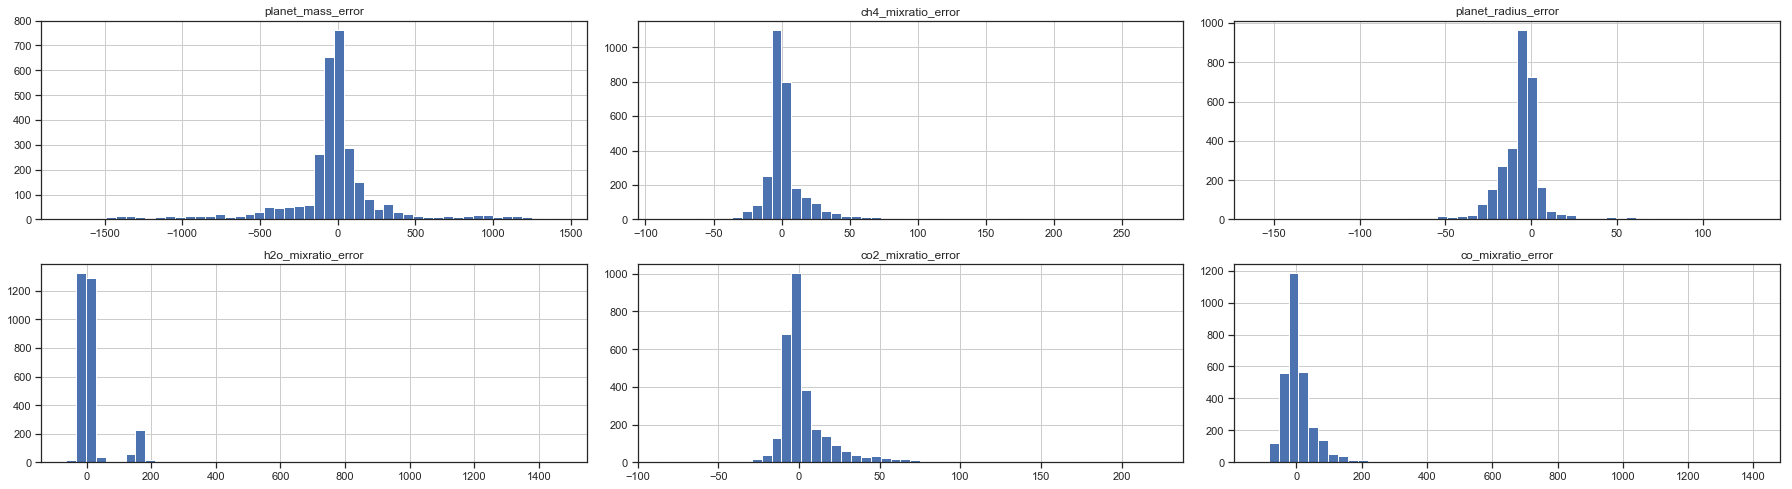

In [6]:
#params = ['planet_mass','temp_profile','ch4_mixratio','planet_radius','h2o_mixratio','co2_mixratio','co_mixratio']
params = ['planet_mass','ch4_mixratio','planet_radius','h2o_mixratio','co2_mixratio','co_mixratio']


plt.figure(figsize=((25,10)))
for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.title(param+'_error')
    plt.hist(df[param+'_error'], bins=50)
    plt.grid()
    plt.tight_layout()

# Grab the $n$ sigma errors

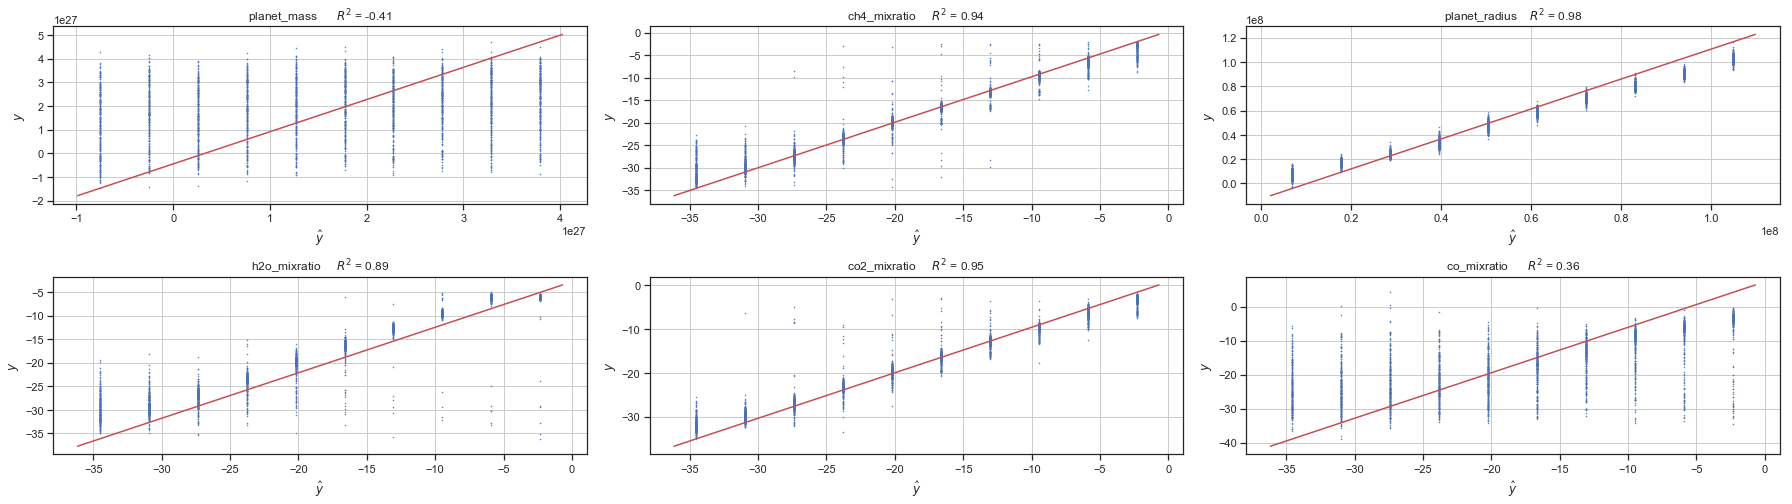

In [10]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    y_hat = df[param+'_real']
    y = df[param+'_inpainted']
    
    r2 = r2_score(y_hat, y)
    
    plt.subplot(3,3,i+1)

    plt.title(param +' \t $R^2$ = %.2f' % r2)
    plt.plot(y_hat, y, '.', ms=1)
    #plt.ylim(plt.xlim()) # set y axis range the same as x axis range
    plt.plot(plt.xlim(), plt.ylim(), ls="-", c='r')
    
    plt.xlabel(r"$\hat{y}$")
    plt.ylabel(r"$y$")
    plt.grid()
    plt.tight_layout()

In [ ]:
# Error per parameter

In [ ]:
params

In [ ]:
param = params[5]
print('Param: ', param)

uniques = df[param+'_real'].unique()
print('Uniques: ',uniques)

In [ ]:
counts = []
stds = []
for unique in uniques:
    t = df[param+'_error'][(df[param+'_real'] == unique)]
    std = t.std()
    count = t.count()
    print(count, std)
    
    counts.append(count)
    stds.append(std)
    
plt.plot(uniques, stds, '.')
plt.grid()
plt.xlabel('uniques')
plt.ylabel('stds')

In [ ]:
params